## Clustering and Dimensionality Reduction

Earlier we have seen supervised learning methods, where we needed labelled dataset, i.e. for each object we needed to know it's class. However, in some cases it is possible to do some machine learning without knowing the class, based on some inherent properties of the dataset. In this module, we will consider **unsupervised learning**.

Let's start again with [MNIST Dataset](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)):

In [1]:
import sklearn as sk
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

mnist = fetch_openml('mnist_784')

X = mnist.data.to_numpy()/255.0
Y = mnist.target.to_numpy().astype(np.uint8)
print(X.shape, Y.shape)

We can use the property of **geometric proximity** of digit images to implement classification.

### KNN Classifier

**K nearest neighbors** algorithm is used in the case when all objects have some similarity or proximity measure. For digits, we can conside mean squared error of pixel arrays to be such a measure:

In [65]:
def dist(X,Y):
    return np.sum((X-Y)*(X-Y))

for _ in range(15):
    i,j = np.random.randint(0,len(X),size=2)
    print(f"Distance between {Y[i]} and {Y[j]} is {dist(X[i],X[j])}")

Distance between 3 and 5 is 98.03048058439063
Distance between 9 and 1 is 147.59152633602463
Distance between 4 and 2 is 126.84355247981547
Distance between 8 and 2 is 109.93488658208382
Distance between 0 and 6 is 169.46332948865822
Distance between 1 and 8 is 69.60976547481738
Distance between 1 and 9 is 68.28988850442138
Distance between 4 and 7 is 98.85897731641677
Distance between 5 and 5 is 89.75872356785852
Distance between 1 and 1 is 28.31755478662053
Distance between 1 and 3 is 104.60735101883891
Distance between 1 and 1 is 27.370611303344873
Distance between 7 and 6 is 124.33776239907728
Distance between 7 and 0 is 129.65925413302577
Distance between 4 and 6 is 72.35318723567859


You can run this code several times and notice that the distance between images of the same class is typically smaller that the distance between objects of different classes. 

Taking this into account, we can suggest the following algorithm for classification of input image $I$:

1. Look for such an image $X_i$ from our training dataset $\{\langle X_k,Y_k\rangle\}_{k=1}^N$, such that $\mathrm{dist}(X_i,I)\to\min$.
2. As a result return the label of this element $Y_i$.

> To speed up our demo, let's use the dataset of 10000 images. You can see how this example works on the full dataset, but be prepared to wait longer.

In [66]:
X_train, X_test, Y_train, Y_test = \
   sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=2000)

def classify(input_img):
    i = np.argmin([dist(x,input_img) for x in X_train])
    return Y_train[i]

n = 20
correct = 0
for x,y in zip(X_test[:n],Y_test[:n]):
    r = classify(x)
    print(f"{y} classified as {r}")
    correct += (y==r)
print(f"Accuracy: {correct/n}")
    

2 classified as 2
3 classified as 3
5 classified as 5
8 classified as 5
2 classified as 2
5 classified as 5
0 classified as 0
0 classified as 0
4 classified as 4
0 classified as 6
0 classified as 0
9 classified as 9
3 classified as 3
8 classified as 1
9 classified as 9
0 classified as 0
0 classified as 0
4 classified as 4
0 classified as 0
0 classified as 0
Accuracy: 0.85


We have managed to implement a classifier in few lines of code! It is called KNN classifier with K=1.

To improve the accuracy, we can suggest the following:

1. Select K nearest to I elements from the dataset 
2. From this set, chose the label that appears most of the time.

For example, if nearest digits to our input image would be [8,3,3], we will return 3.

KNN classifier is also implemented in Scikit Learn:

In [67]:
import sklearn.neighbors

res=[]
for i in range(1,10):
    model = sk.neighbors.KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train,Y_train)
    acc = sk.metrics.accuracy_score(Y_test,model.predict(X_test))
    print(f"Accuracy for k={i} is {acc}")
    res.append(acc)

Accuracy for k=1 is 0.941
Accuracy for k=2 is 0.9295
Accuracy for k=3 is 0.9425
Accuracy for k=4 is 0.939
Accuracy for k=5 is 0.942
Accuracy for k=6 is 0.9385
Accuracy for k=7 is 0.94
Accuracy for k=8 is 0.939
Accuracy for k=9 is 0.9355


You can notice that some value of k yields highest accuracy. Thus, we can run several experiments and select such k. This optimization is called **hyperparameter optimization**.

In order to measure "fair" accuracy of the final model, we can not use the same test set as for optimization. Thus, in this case we split original dataset into three datasets:
* **Training set** is used for training all models
* **Validation set** is used to optimize hyperparameters
* **Test set** is used to measure the final metrics of the model

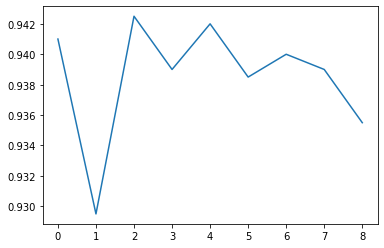

In [68]:
plt.plot(res)
plt.show()

### Clustering. K-Means.

In KNN we we still solving classification problem - even though we looked at distances between objects in the feature space. However, we can try to solve a different problem - how to separate all digits in the feature space into some compact clusters? This would correspond to **clustering problem**, and we just need to look at digit images themselves, we do not need to know corresponding digit labels.

Most known clustering algorithm is **K-Means**. Suppose we want to split the oroginal set of objects $X$ into $k$ disjoint clusters $X_i$, such that $\bigcup\limits_i X_i = X$ and $X_i\cap X_j=\emptyset$ for all $i\neq j$, and in such a way as to minimize total distance between objects inside clusters.

Since it is complex to measure all pariwise distances, the latter is typically replaced by the distance from all points in the cluster $X_i$ to its **center of mass** $c_i$ (they are also called **centroids**). We want to minimize this distance for all clusters, i.e.
\begin{equation}
\sum_{i=1}^k \sum_{x\in S_i} (x-c_i)^2 \to \min
\end{equation}

K-Means is an interative algorithm. Initially we chose centroids and cluster distribution randomly, and at each step we re-compute the centroids and re-group objects within clusters. Algorithm completes when there are no further re-grouping that yields smaller distance.

Let's use K-Means from SkLearn:

In [69]:
import sklearn.cluster

model = sk.cluster.KMeans(n_clusters=10).fit(X)

During clustering, **centroids** are also computed. Let's have a look at them:

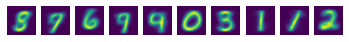

In [70]:
fig,ax = plt.subplots(1,10)
for i,im in enumerate(model.cluster_centers_):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

In [75]:
model.labels_

array([0, 5, 4, ..., 1, 0, 2])

Most of the centroids correspond to digits, and we have grouped digits together without any preliminary labeling. However, it is likely that some digit would correspond to several clusters, and some digits can be assigned to one cluster. This is partly because of the fact that K-Means does not guarantee **global minimum** for the distance in formula (1), but only **local minimum**.

Let's see objects in one of the clusters (you can set `c` according to the number of cluster you want to see):

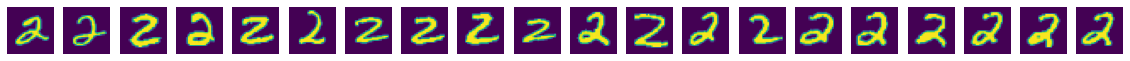

In [77]:
c = 9
res = [ x for x,l in zip(X,model.labels_) if l==c]

fig,ax = plt.subplots(1,20,figsize=(20,5))
for i,im in enumerate(res[:20]):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

To understand how the code above works, let's look at `labels_` property:

In [ ]:
print(f"Shape: {model.labels_.shape}")
print(model.labels_[:10])

In this vector, for each element from the original set $X$ there is a number of corresponding cluster. Having those labels, we have almost solved the classification problem - we just need to build correspondence between cluster number and digit, and to find parameters of the model to achieve best 1-1 or 1-few correspondence between clusters and digits

#### Example: Olivetti Faces

Consider more high-dimensional example - [Olivetti Faces](https://scikit-learn.org/0.19/datasets/olivetti_faces.html). Dataset can be loaded directly from Scikit Learn:

In [78]:
from sklearn.datasets import fetch_olivetti_faces
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
faces.shape

(400, 4096)

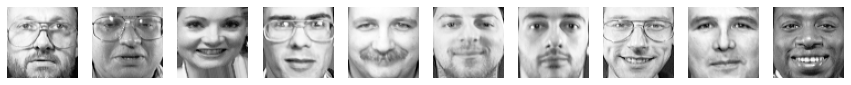

In [82]:
fig,ax = plt.subplots(1,10,figsize=(15,5))
for i in range(10):
    ax[i].imshow(-faces[i].reshape(64,64),cmap='Greys')
    ax[i].axis('off')
plt.show()

We will apply clustering and look at centroids:

C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


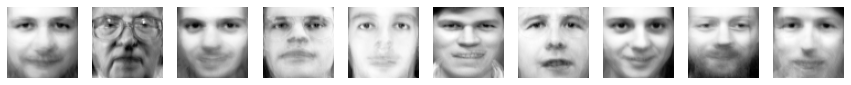

In [83]:
model = sk.cluster.KMeans(n_clusters=40).fit(faces)

fig,ax = plt.subplots(1,10,figsize=(15,5))
for i in range(10):
    ax[i].imshow(-model.cluster_centers_[i].reshape(64,64),cmap='Greys')
    ax[i].axis('off')
plt.show()

Now let's look inside one of the classes:

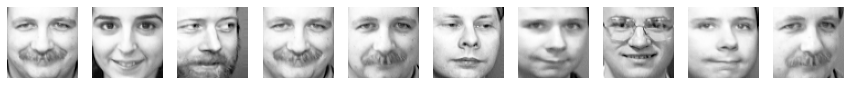

In [85]:
c = 0
res = [ x for x,l in zip(faces,model.labels_) if l==c]

fig,ax = plt.subplots(1,min(10,len(res)),figsize=(15,5))
for i,im in enumerate(res[:10]):
    ax[i].imshow(-im.reshape(64,64),cmap='Greys')
    ax[i].axis('off')
plt.show()

#### Example 2: Photo Colors

Consider this photograph:

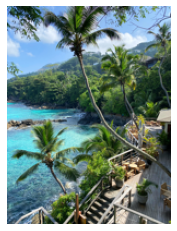

In [87]:
from PIL import Image

img = Image.open("../../../data/datingscout-u7nxI32spEk-unsplash.jpg")
img = img.resize((150,200))
img = np.array(img)/255.0
plt.imshow(img)
plt.axis('off')
plt.show()

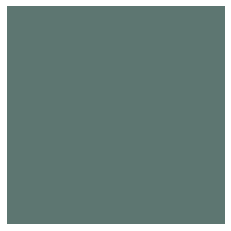

In [92]:
def show_color(c,ax=plt):
    t = np.zeros(shape=(10,10,3))
    t[:] = c
    ax.imshow(t)
    ax.axis('off')
    
show_color(img.mean(axis=(0,1)))

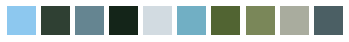

In [96]:
n_clusters = 10

X = img.reshape(-1,3)
km = sk.cluster.KMeans(n_clusters=n_clusters).fit(X)

fig,ax = plt.subplots(1,n_clusters)
for i in range(n_clusters):
    show_color(km.cluster_centers_[i],ax[i])

## Dimensionality Reduction

K-Means separates our dataset into clusters, but we cannot observe that visually, because each object is represented by a point in 784-dimensional space. To visually see what does on, we need to somehow project that into 2D-space.

This process is called **dimensionality reduction**. The most known method is called **[Principal Component Analysis](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82)** (PCA).

The main idea of the method is the following. Imagine some set of point of the  2D-plane. If we want to reduce the dimensionality to 1, we can transform original points and project them onto 1D straight line (or "look" at them from different angles). To make those point more clearly visible, we need to select such point of view as to maximize the spread between points.

The same process can be performed for arbitrary $n$-dimensional space. To reduce dimensionality by 1, we are looking for such direction (called **principal component**), which ensures highest spread between points when projecting them onto $n-1$-dimensional space. We can then repeat the process until we reach required number of dimensions.

Let's have a look at how PCA can be applied to our dataset:

In [97]:
import sklearn.decomposition

X = mnist.data.to_numpy()/255.0

X2 = sk.decomposition.PCA(n_components=2).fit_transform(X)
X2[:10]

array([[ 0.47942559, -1.23982273],
       [ 3.96271862, -1.13701156],
       [-0.2313551 ,  1.54388463],
       [-3.12534103, -2.3823227 ],
       [-1.53458461,  2.86185892],
       [ 0.72926648,  0.87827428],
       [-2.86464532, -0.6356414 ],
       [ 1.97445887, -1.21072551],
       [-3.42961818, -0.33075107],
       [-1.19223321,  1.81822441]])

We have received 2D-vectors corresponding to our original digits. Since we know digit classes for all original data, we can plot those 2D-points together with corresponding classes, to see whether different digits are somehow separated:

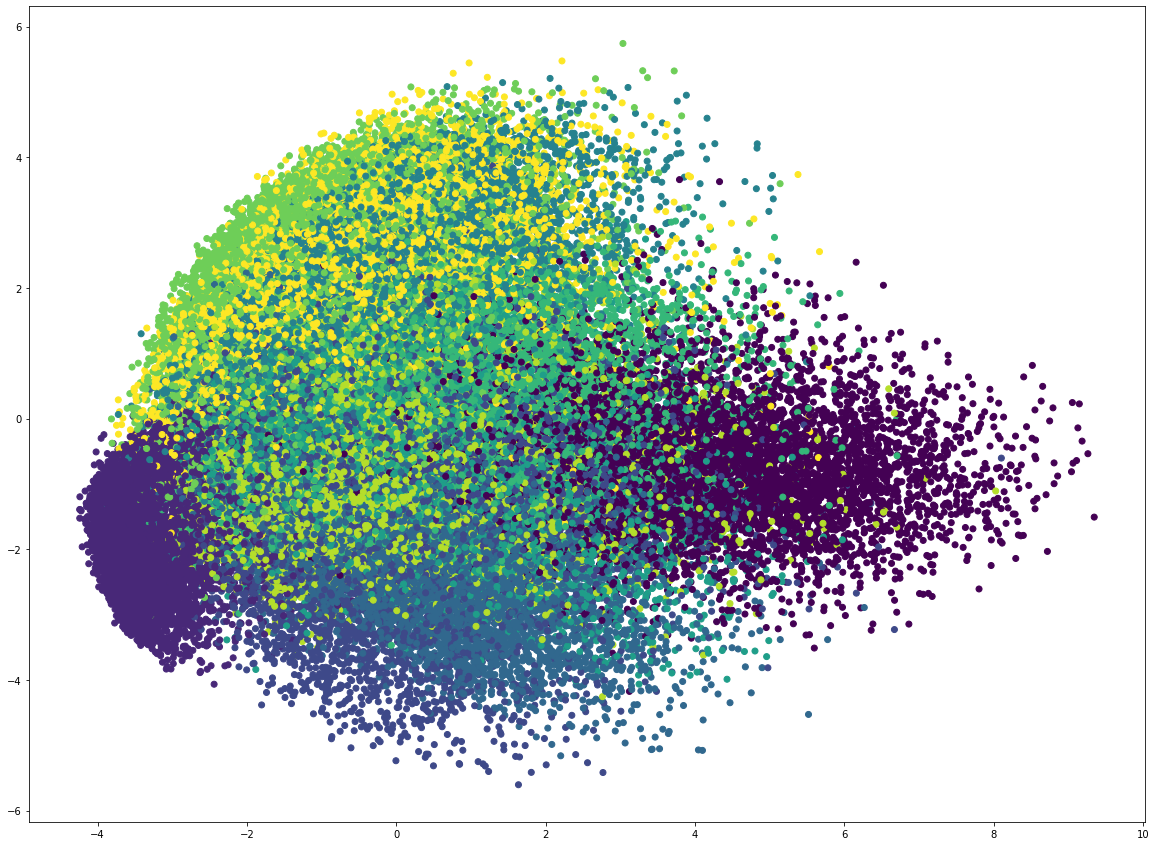

In [98]:
plt.figure(figsize=(20,15))
plt.scatter(X2[:,0],X2[:,1],c=Y)
plt.show()

It can be noticed that more or less the same digits are grouped together, yet there is a lot of overlap. For clarity, we can plot only two digits at a time

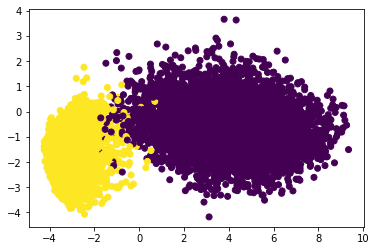

In [99]:
def plot_subset(s):
    tX = np.array([x for x,c in zip(X2,Y) if c in s])
    col = np.array([c for c in Y if c in s])
    plt.scatter(tX[:,0],tX[:,1],c=col)
    plt.show()

plot_subset({0,1})

So, point clouds for 0 and 1 are clearly linearly separable. We can easily apply logistic regression and get almost perfect result!

Now let's look at more "similar" digits:

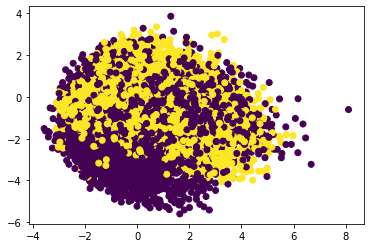

In [100]:
plot_subset({2,5})

Those point clouds are much less separated, and clearly there could be a problem with their classifiction.

Dimensionaliy reduction techniques are very useful for multi-dimensinal data visualization, and to make sure that classes are separable. We can use it as a tool to understand data better before applying clustering or classification techniques.

## Example: Country Analysis

Another way clustering is used in real life is to understand similarities within data. To see an example, consider [dataset of different countries](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data), and try to group them together.

In [101]:
import pandas as pd
df = pd.read_csv('../../../data/Country-data.csv')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


Here are the features:
* `child_mort` - child mortality under 5 years, per 1000 ppl.
* `exports` - exports, in % of GDP 
* `health` - healthcare expenditure, in % of GDP 
* `imports` - imports, in % of GDP 
* `Income` - income per capita
* `Inflation` - inflation, GDP grown YoY
* `life_expec` - average life expectancy 
* `total_fer` - number of children per woman, on average
* `gdpp` - GDP


In [104]:
df.describe().T[['mean','min','max']]

,mean,min,max
child_mort,38.270060,2.6000,208.00
exports,41.108976,0.1090,200.00
health,6.815689,1.8100,17.90
imports,46.890215,0.0659,174.00
income,17144.688623,609.0000,125000.00
inflation,7.781832,-4.2100,104.00
life_expec,70.555689,32.1000,82.80
total_fer,2.947964,1.1500,7.49
gdpp,12964.155689,231.0000,105000.00


Let's start with PCA, to see if there are any visually obvious clustering within the data:

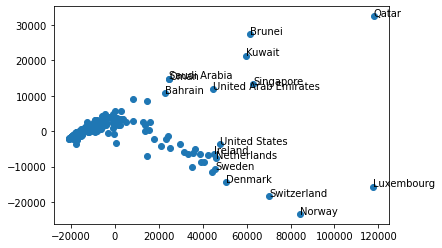

In [105]:
features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

names = df['country']
res = sk.decomposition.PCA(n_components=2).fit_transform(df[features])
plt.scatter(res[:,0],res[:,1])
for n,x,y in zip(names,res[:,0],res[:,1]):
    if x>45000 or y>10000:
        plt.annotate(n,(x,y))
plt.show()

Some of the countries are clearly separated. To understand which countries are those, we annotate the points there are further away from the center.

You can notice that we get very large values after PCA. Also, because all of the features are not scaled, we are risking to take some of them into account to the larger degree than the others. Let's scale all features before PCA:

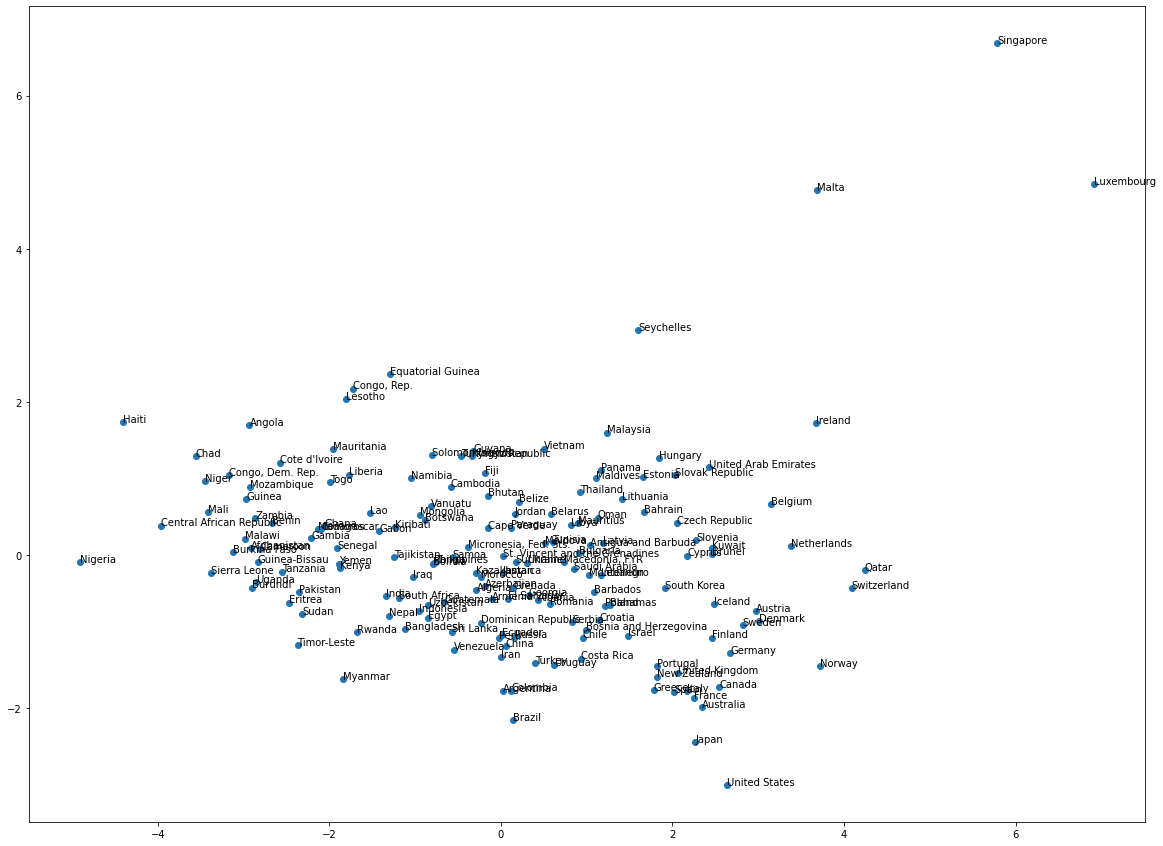

In [106]:
scaler = sk.preprocessing.StandardScaler()
dfs = scaler.fit_transform(df[features])

res = sk.decomposition.PCA(n_components=2).fit_transform(dfs)
plt.figure(figsize=(20,15))
plt.scatter(res[:,0],res[:,1])
for n,x,y in zip(names,res[:,0],res[:,1]):
    if True or y>2.5 or x<-4 or x>3:
        plt.annotate(n,(x,y))
plt.show()

Now point are more uniform, but the same countries are clearly separated again (they are however in another part of the graph, because PCA does not guarantee having each time the same coordinate system).

Now let's do the clustering. However, it is not obvious how many clusters we should specify. To understand that, we can try out different parameters, and look at the value of **inertia** - total sum of distances between point and corresponding centroids, as in formula (1):

C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

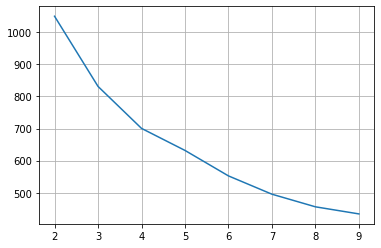

In [107]:
inertias = []
for k in range(2,10):
    km = sk.cluster.KMeans(n_clusters=k).fit(dfs)
    inertias.append(km.inertia_)

plt.plot(range(2,10),inertias)
plt.grid()

Naturally, inertia decreases, and will go up to 0 when the number of clusters corresponds to the number of points. Often, however, we can observe intertia to decrease more rapidly, and then after certain k there would be a change in the graph, when this rapid decrease stops. It makes sense to use corresponding value of k, in our case - 4 or 5:

In [120]:
nclusters = 7
km = sk.cluster.KMeans(n_clusters=nclusters).fit(dfs)
km.labels_

C:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 3, 4, 0, 3, 4, 4, 1, 1, 4, 3, 3, 4, 3, 3, 1, 3, 0, 3, 4, 3, 5,
       4, 1, 3, 0, 5, 3, 0, 1, 3, 0, 0, 3, 4, 4, 0, 0, 0, 3, 0, 3, 3, 3,
       1, 4, 4, 4, 3, 0, 0, 3, 3, 1, 1, 0, 0, 3, 1, 0, 1, 3, 4, 0, 5, 3,
       5, 3, 1, 4, 4, 4, 4, 1, 1, 1, 4, 1, 3, 4, 0, 5, 1, 3, 0, 3, 3, 5,
       5, 3, 3, 2, 3, 0, 0, 3, 3, 0, 2, 0, 3, 5, 3, 4, 3, 4, 0, 4, 5, 4,
       1, 1, 0, 6, 1, 3, 0, 3, 3, 4, 4, 3, 1, 1, 3, 4, 5, 4, 4, 0, 3, 3,
       5, 2, 3, 3, 5, 5, 3, 1, 4, 3, 0, 3, 1, 1, 4, 0, 3, 0, 5, 4, 3, 4,
       4, 0, 3, 1, 1, 1, 4, 4, 4, 4, 3, 0, 0])

To undersand those clusters better, we can find typical representatives of each cluster. Centroid coordinates do not correspond to any specific countries in the dataset, but we can find countries that would be closest in terms of distance:

In [121]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, dfs)
names[closest]

63        Guinea
144       Sweden
133    Singapore
24      Bulgaria
47         Egypt
150         Togo
113      Nigeria
Name: country, dtype: object

To further analyze the data, let's add the number of cluster to the original dataset:

In [122]:
df['cluster'] = km.labels_
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,3
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,4
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,3
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,4
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,4
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,3
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,0


We can then look at average value of features by cluster:

In [123]:
d = { x : 'mean' for x in features }
d['country'] = ', '.join

res = df.groupby('cluster').agg(d)
res

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
cluster,,,,,,,,,,
0,92.693939,30.469394,5.160606,38.300000,3679.969697,11.292273,60.375758,5.288788,1782.575758,"Afghanistan, Angola, Benin, Burkina Faso, Came..."
1,5.100000,44.848148,9.361111,37.981481,46833.333333,2.891963,80.437037,1.838519,45322.222222,"Australia, Austria, Belgium, Brunei, Canada, D..."
2,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,"Luxembourg, Malta, Singapore"
3,14.546154,51.163462,6.777115,58.488462,15961.730769,4.300154,74.384615,1.969423,9338.769231,"Albania, Antigua and Barbuda, Bahamas, Bahrain..."
4,29.302703,28.710514,5.353514,31.796376,10779.459459,11.663135,71.810811,2.637838,5216.108108,"Algeria, Argentina, Armenia, Azerbaijan, Bangl..."
5,86.535714,26.622857,9.945000,59.714286,3651.714286,5.877857,56.342857,4.153571,2060.500000,"Botswana, Burundi, Guinea-Bissau, Haiti, Kirib..."
6,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000,Nigeria


We can try to find some relationships in data - eg. how life expectancy depend on the value of health expenditure 

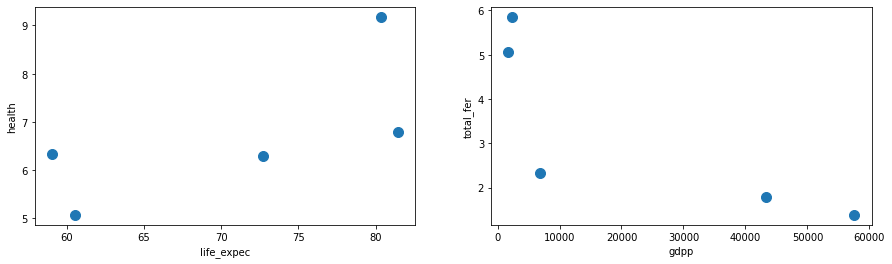

In [114]:
fig,ax = plt.subplots(1,2,figsize=(15,4)) 
res.plot.scatter('life_expec','health',s=100,ax=ax[0])
res.plot.scatter('gdpp','total_fer',s=100,ax=ax[1])
plt.show()

Finally, let's see all clusters:

In [124]:
for c,all in zip(res.index,res['country']):
    print(f"== Cluster: {c} ==\n{all}")

== Cluster: 0 ==
Afghanistan, Angola, Benin, Burkina Faso, Cameroon, Central African Republic, Chad, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Equatorial Guinea, Eritrea, Gabon, Gambia, Ghana, Guinea, Kenya, Lao, Madagascar, Malawi, Mali, Mauritania, Mozambique, Niger, Pakistan, Senegal, Sudan, Tanzania, Timor-Leste, Uganda, Yemen, Zambia
== Cluster: 1 ==
Australia, Austria, Belgium, Brunei, Canada, Denmark, Finland, France, Germany, Greece, Iceland, Ireland, Israel, Italy, Japan, Kuwait, Netherlands, New Zealand, Norway, Portugal, Qatar, Spain, Sweden, Switzerland, United Arab Emirates, United Kingdom, United States
== Cluster: 2 ==
Luxembourg, Malta, Singapore
== Cluster: 3 ==
Albania, Antigua and Barbuda, Bahamas, Bahrain, Barbados, Belarus, Belize, Bhutan, Bosnia and Herzegovina, Bulgaria, Cambodia, Cape Verde, Chile, Costa Rica, Croatia, Cyprus, Czech Republic, El Salvador, Estonia, Fiji, Georgia, Grenada, Guyana, Hungary, Jordan, Kyrgyz Republic, Latvia, Lebanon, Lib

**Exercise**:
1. Experiment with the # of clusters and see which groups of countries you will get
1. Try clustering without scaling, and compare the results
1. Try using `MinMaxScaler` to scale the data
1. Implement scaling together with clustering in one pipeline (hint - use `ColumnTransformer` to scale only numeric features)